# PAN and catchment boundaries analysis

In [1]:
import geopandas as gpd
import pandas as pd
from shapely import within, centroid, intersects, intersection
import os
## find the directory of the python (assures compatibility)
python_directory = os.path.abspath("")
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import copy
import math
import numpy as np
import warnings
warnings.filterwarnings("ignore")

from models import Optimise_PANs_LSOAs, Optimise_PANs_Schools, Optimise_PANsCatchment_Schools, Optimise_PANsCatchment_LSOAs

## Data preparation

This includes adding the information required for models in the analysis phase. This includes the estimated number of 5 year olds:
- Approximately 20% of the 5 to 9 year olds in each LSOA are considered 5 year olds
- This generates a total number of 5 year 2433 student
- This estimate is acceptable as it aligns with Dennet's report in this link [https://adamdennett.github.io/BH_Secondary_Admissions_Analysis/BH_Sec_Sch_Analysis.html](https://adamdennett.github.io/BH_Secondary_Admissions_Analysis/BH_Sec_Sch_Analysis.html)

In [2]:
## load the PANs
PANs = pd.read_csv(rf"{python_directory}/data/Yr7_admissions.csv")

## load the maps
schools = gpd.read_file(rf"{python_directory}/data/brighton_sec_schools.geojson")
lsoa = gpd.read_file(rf"{python_directory}/data/BrightonLSOA_Clean.geojson")
students = gpd.read_file(rf"{python_directory}/data/BrightonLSOA_Clean.geojson")
catchment = gpd.read_file(rf"{python_directory}/data/catchment_02.geojson")

## transform lsoa and students dataframes to EPSG:27700 (For the UK)
lsoa.to_crs(epsg="27700", inplace=True)
students.to_crs(epsg="27700", inplace=True)
catchment.to_crs(epsg="27700", inplace=True)

## Print the current CRS
print(f"CRS | schools = {schools.crs}, LSOA = {lsoa.crs}, students LSOA = {students.crs}")


CRS | schools = EPSG:27700, LSOA = EPSG:27700, students LSOA = EPSG:27700


In [3]:
## Identify the catchment ID of a polygon geometry based based on the catchment that contains it
# Used when resetting the parameters
def polygon_catchment_ID(geometry_df, geometry_index, catchment):
    geometry = geometry_df.at[geometry_index, "geometry"]
    portion_list = list()
    ## identify the portion of the polygon which falls within the catchments
    for i in catchment.index:
        portion_list.append(portion_within(geometry, catchment.at[i,"geometry"]))
    ## report the catchment Id which includes the highest portion of the polygon
    i = portion_list.index(max(portion_list))
    return catchment.at[i, "catchment_ID"]

## Identify the catchment ID of a point geometry based based on the catchment that contains it
# Used when resetting the parameters
def point_catchment_ID(geometry_df, geometry_index, catchment):
    geometry = geometry_df.at[geometry_index, "geometry"]
    for i in catchment.index:
        # if the centroid of the geometry is within the catchment geometry
        if within(centroid(geometry), catchment.at[i,"geometry"]): return catchment.at[i, "catchment_ID"]

def portion_within(geometry_a, geometry_b):
    intersection_area = intersection(geometry_a, geometry_b).area
    portion = intersection_area / geometry_a.area
    return portion


    

## generate additional attribute columns
def reset_parameters(schools=schools, students=students, catchment=catchment):
    ## Catchments
    # column for the catchment id
    catchment["catchment_ID"] = [index + 1 for index in catchment.index]
    ## Schools 
    # Column to assign the total number of students in each school point
    # Column to assign colours
    # Column to assign catchment ID
    schools["students_total"] = [0 for index in schools.index]
    schools["catchment_ID"] = [0 for index in schools.index]
    schools["catchment_ID"] = [point_catchment_ID(schools, i, catchment) for i in schools.index]
    schools["colour"] = ["" for index in schools.index]
    ## LSOA including number of students
    # Column to assign the name of the schools
    # Column to assign the estimated number of 5 year olds
    # Column to assign catchment ID
    # Column to assign colours
    students["school"] = ["" for index in students.index]
    students["5_est"] = [math.floor(n * 0.19288) for n in students["5_9_total"]]
    students["catchment_ID"] = [0 for index in students.index]
    students["catchment_ID"] = [polygon_catchment_ID(students, i, catchment) for i in students.index]
    students["catchment_ID_school"] = [0 for index in students.index]
    students["colour"] = ["" for index in students.index]
    

reset_parameters()
print("Attributes created and reset in all DataFrames")
print("--------------------")
print("LAOAs visualised based on catchment area ID")

## plot the lsoa with the number of students
# fig = students.plot(column="catchment_ID", label="Catchment ID", legend=True, figsize=(20,10))
# schools.plot(ax=fig, column="catchment_ID", edgecolor='black', markersize=60)
# catchment.plot(ax=fig, facecolor="none", edgecolor="black", label="Catchment")
# plt.show()
# plt.close()
students.explore(column="catchment_ID", legend=True)

Attributes created and reset in all DataFrames
--------------------
LAOAs visualised based on catchment area ID


Apply spatial joins to assign catchment IDs to schools and LSOAs

Visualisation for the number of estimated 5 year olds in Brighton and the school locations.

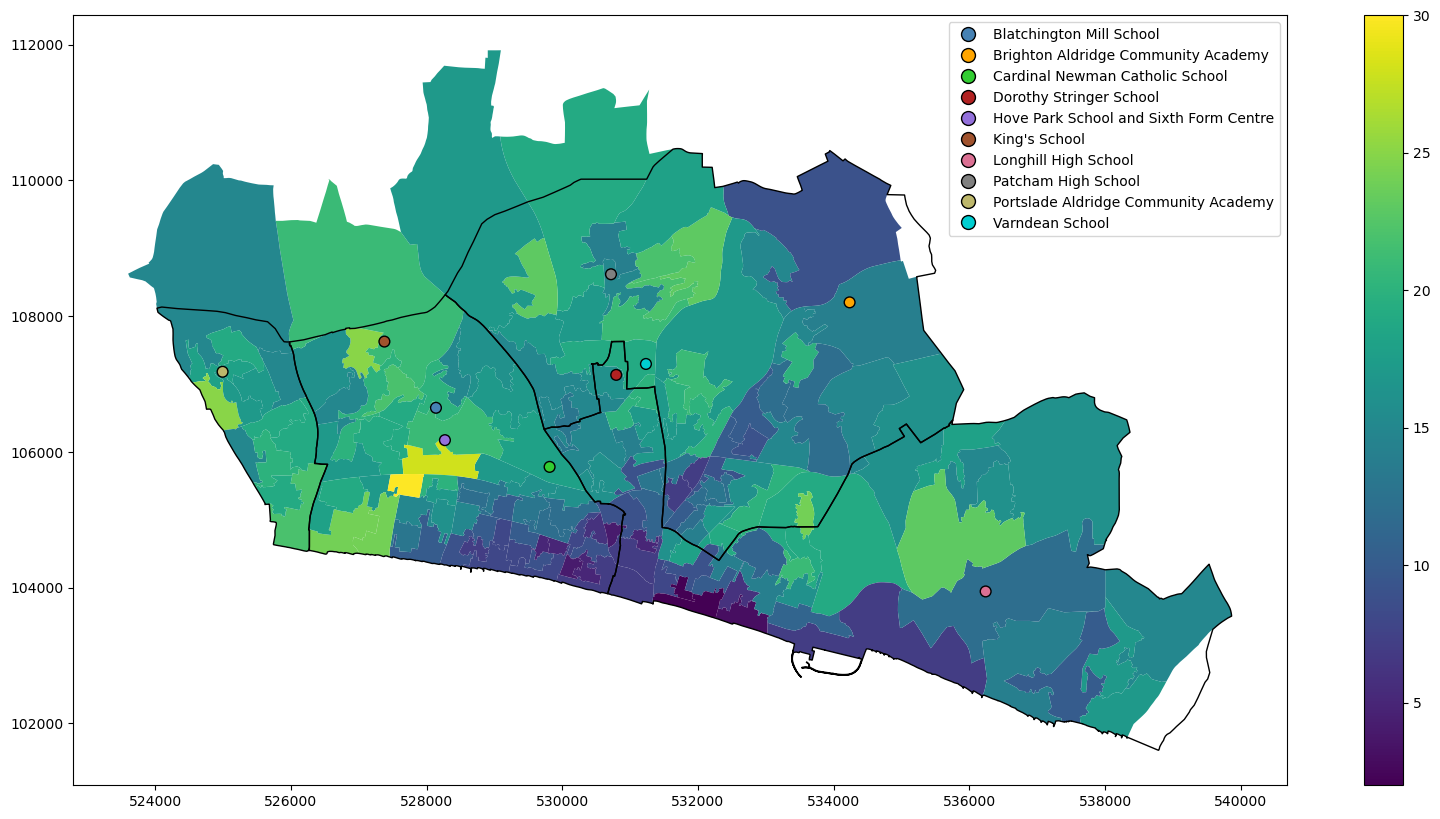

In [17]:
## define colours
colours = {
    "Blatchington Mill School": "steelblue",
    "Brighton Aldridge Community Academy": "orange",
    "Cardinal Newman Catholic School": "limegreen",
    "Dorothy Stringer School": "firebrick",
    "Hove Park School and Sixth Form Centre": "mediumpurple",
    "King's School": "sienna",
    "Longhill High School": "palevioletred",
    "Patcham High School": "gray",
    "Portslade Aldridge Community Academy": "darkkhaki",
    "Varndean School": "darkturquoise",
}

## create custom legend
def create_custom_legend_handles():
    handles, labels = plt.gca().get_legend_handles_labels()
    extend_list = []
    for school_str in colours:
        point = Line2D([0], [0], label=school_str, marker='o', markersize=10, markeredgecolor="black", markerfacecolor=colours[school_str], linestyle="")
        extend_list.append(point)
    handles.extend(extend_list)
    return(handles)

## plot the lsoa with the number of students
fig = students.plot(column="5_est", label="5 to 15 year olds", legend=True, figsize=(20,10))
schools["colour"] = [colours[schools.at[i, "establishment_name"]] for i in schools.index]
schools.plot(ax=fig, color=schools["colour"], edgecolor='black', markersize=60, legend=True)
catchment.plot(ax=fig, facecolor="none", edgecolor="black", label="Catchment")
plt.legend(handles=create_custom_legend_handles())
plt.show()
plt.close()

## Analysis

The analysis uses a set of models that assign students to schools using Euclidean distances as the driver for the assignment process. We introduce 2 models using the following logics:
- Model 1: Each school proceeds to select the closes LSOA to it until taking any further LSOA exceeds its allocated PAN
- Model 2: Each LSOA is assigned to the nearest school that can enlist this LSOA's students without exceeding its PAN

Each model generates a spatial distribution of school catchments that may not align with the catchment zones. By comparing the results to the catchment zones, we can identify areas where the catchment zones may force students to enlist in schools at longer distances from their LSOA.
Further, by observing spatial areas that have been forcibly assigned to a distant school, we can make conclusions on the suitability of the PAN restrictions used in 2024.

### Optimise ignoring catchments

#### Model 1.1: loop through schools and assign LSOAs

As previously mentioned, the first model optimises using the logic that each school proceeds to select the closes LSOA to it until taking any further LSOA exceeds its allocated PAN. 
The model applies the following workflow:
- Order the schools starting from "Dorothy Stringer School" followed by the next closest school (School B), School B is then followed by its next closest (excluding "Dorothy Stinger School"), and so on.
- Each one of the 10 schools selects one LSOA and takes in all the 5 year olds within it if that does not lead to exceeding its PAN
- We repeat for as many rounds as needed until all schools have almost reached their PANs

##### Key observations

Map 1 shows relevant spatial trends within central region of Brighton:
- The PAN of "Patcham high school" covers students beyond its surrounding areas. This leads to the emergence of dispersed LSOAs south of "Varndean" and "Dorothy Stringer" that end up enlisted in "Patchman High School"
- This may imply that the PANs of "Varndean" (whose LSOAs are in direct proximity to the "Patcham" LSOAs) is not high enough to accomodate all the students within their proximate areas.
- Similar to "Patcham high school", the PAN of "Cardinal Newman" covers more students beyond its most approximate areas. This creates an cluster of LSOAs that end up enlisting in "Cardinal Newman" despite being closer to "Dorothy Stringer" or "Longhill"

Graph 1 shows that no school exceeds its PAN. This validates the model's logic in terms of optimising for PANs at the expense of catchment areas.

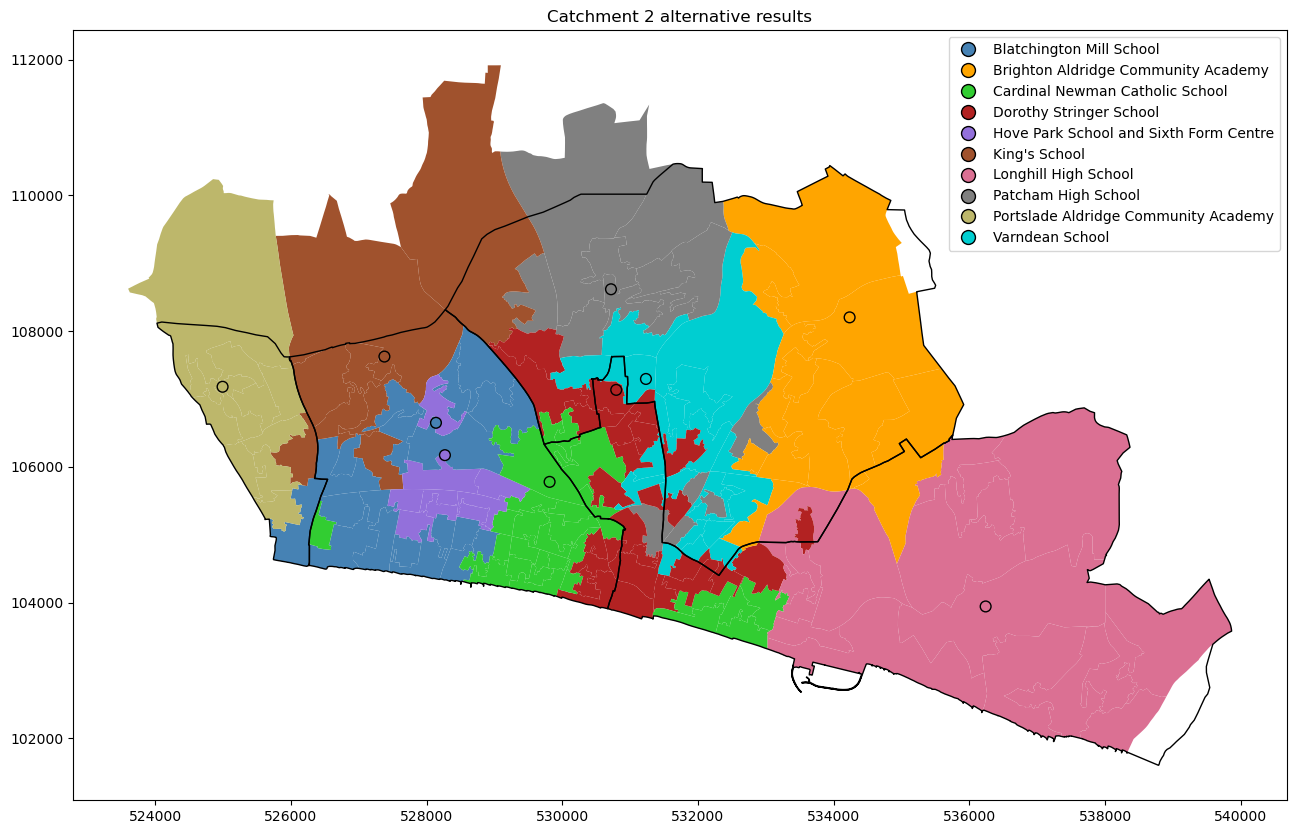

In [18]:
## reset the parameters and run the model
reset_parameters()
Optimise_PANs_Schools(schools=schools, students_lsoa=students, PANs=PANs)
## plot the results
students["colour"] = [colours[students.at[i, "school"]] for i in students.index]
schools["colour"] = [colours[schools.at[i, "establishment_name"]] for i in schools.index]
fig = students.plot(color=students["colour"], legend=True, figsize=(18,10))
schools.plot(ax=fig, color=schools["colour"], edgecolor='black', markersize=60, legend=True)
catchment.plot(ax=fig, facecolor="none", edgecolor="black", label="Catchment")
plt.title("Map 1: Model 1 results")
plt.legend(handles=create_custom_legend_handles())
plt.show()
plt.close()

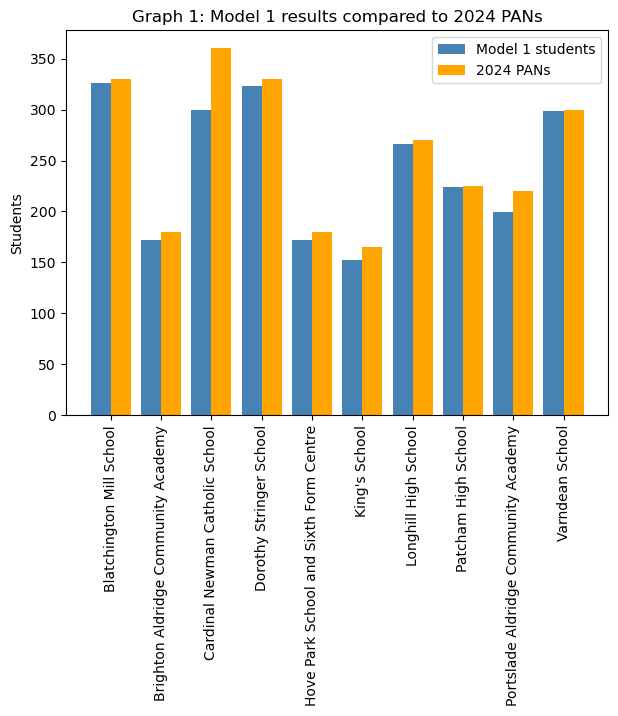

In [6]:
## create ordered lists
students_total_plot, PANs_2024_plot = list(), list()
x_axis_list = list()
for school_str in PANs["school"]:
    students_total_plot.append(int(schools[schools["establishment_name"] == school_str]["students_total"]))
    PANs_2024_plot.append(int(PANs[PANs["school"] == school_str]["pan2024"]))
    x_axis_list.append(school_str)

## plot target PAN numbers
x_axis = np.arange(len(x_axis_list))
width = 0.4
plt.figure(figsize=(7,5))
plt.title("Graph 1: Model 1 results compared to 2024 PANs")
plt.bar(x_axis - (width / 2), students_total_plot, width, color="steelblue", label="Model 1 students")
plt.bar(x_axis + (width / 2), PANs_2024_plot, width, color="orange", label="2024 PANs")
plt.xticks(x_axis, x_axis_list, rotation=90)
plt.ylabel("Students")
plt.legend()
plt.show()
plt.close()

#### Model 1.2: loop through LSOAs and assign schools

As previously mentioned, the second model optimises using the logic that each LSOA is assigned to the nearest school that can enlist this LSOA's students without exceeding its PAN. 
The model applies the following workflow:
- Iterate through the LSOAs based on their IDs
- Assign the students in each LSOA to the closest school that can take the students without exceeding its PAN

The order of choosing the LSOA can generate slighly different spatial trends from Model 1. However, the results are expected to be qualitatively similar as both use Eculidean distances within their logic.

##### Key observations

Map 2 shows relevant spatial trends that align with the results from Model 1:
- The PAN of "Patcham high school" still covers students beyond its surrounding areas. However, unlike model 1, it attracts students in LSOA that are significantly proximate to "Varndean" and "Dorothy Stringer" (including the LSOA that includes "Varndean"). The differences in the locations of the "Patcham high school" LSOAs that are closer to the other 2 schools is an artifact of the different logics of the models. However, both cases indicate that the high PAN of Patcham is the cause of this observation.
- Similar to Model 1, this can imply that the PANs of "Varndean" and "Dorothy Stringer" are not high enough to accomodate all the students within their proximate areas.
- Similar to model 1, the PAN of "Cardinal Newman" covers more students beyond its most approximate areas. This creates an cluster of LSOAs that end up enlisting in "Cardinal Newman" despite being closer to "Dorothy Stringer" or "Longhill"
- It is also relevant to indicate that "King's" enlists students in southern LSOAs closer to "Hove Park" and "Blatchington Mill". This is also partly observed in model 1 (though the "King's" LSOA are not spatially disconnected in Model 1). This implies that the PAN of King's is higher than the number of students within its Eucledian proximity.
- "Dorothy Stringer" enlists a distant LSOA in the east. . This can be an artifact of "Patcham" encroaching on "Dorothy's" proximate LSOAs alongside "Cardinal Newman's" encroachement on its south LSOAs. This creates a situation where students in a distant LSOAs (south -- and one in the east) have to enlist in "Dorothy Stringer" despite the long Euclidean distance.


Similar to graph 1, graph 2 shows that no school exceeds its PAN. This validates the model's logic in terms of optimising for PANs at the expense of catchment areas.

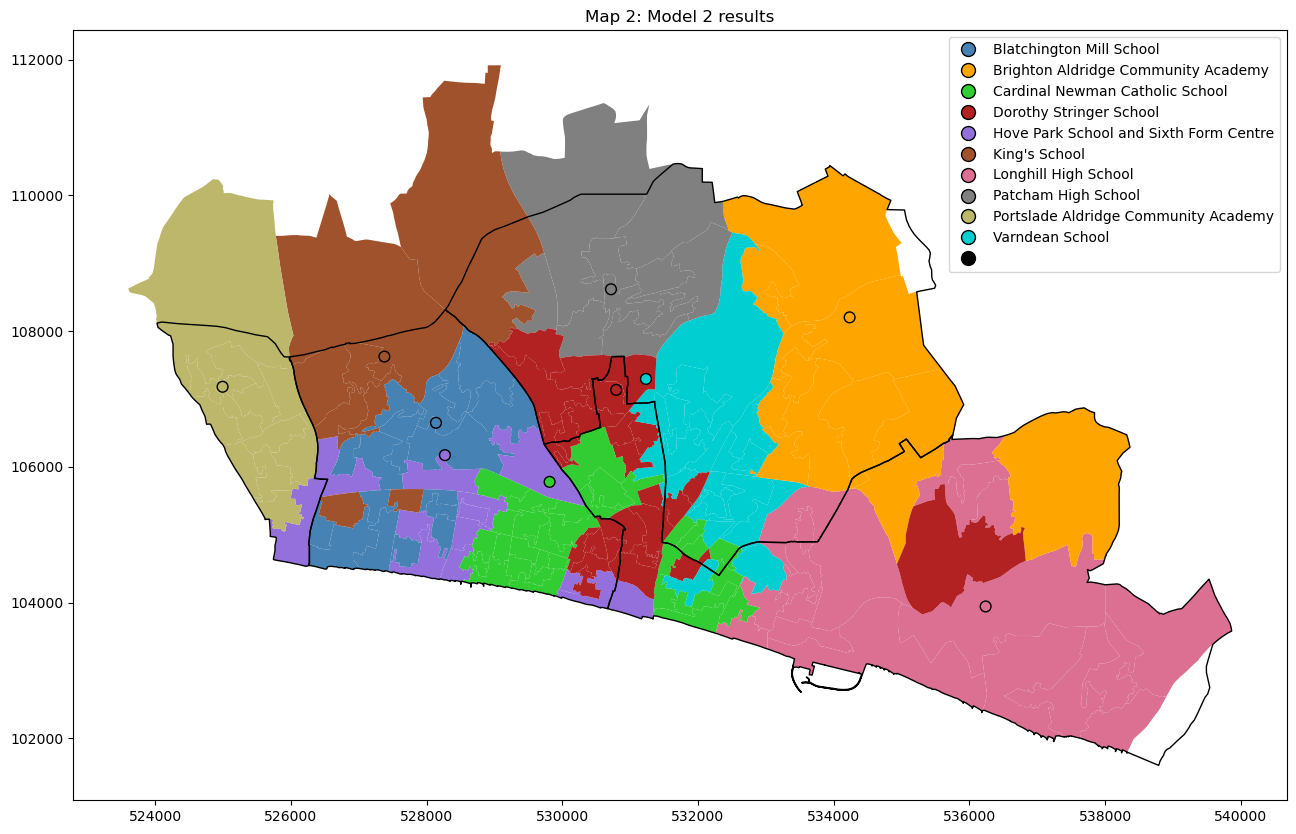

In [7]:
## Run the model
reset_parameters()
Optimise_PANs_LSOAs(schools=schools, students_lsoa=students, PANs=PANs)
## Plot the map
students["colour"] = [colours[students.at[i, "school"]] for i in students.index]
schools["colour"] = [colours[schools.at[i, "establishment_name"]] for i in schools.index]
fig = students.plot(color=students["colour"], legend=True, figsize=(20,10))
schools.plot(ax=fig, color=schools["colour"], edgecolor='black', markersize=60, legend=True)
catchment.plot(ax=fig, facecolor="none", edgecolor="black", label="Catchment")
plt.title("Map 2: Model 2 results")
plt.legend(handles=create_custom_legend_handles())
plt.show()
plt.close()

Achieved PANs in this scenario

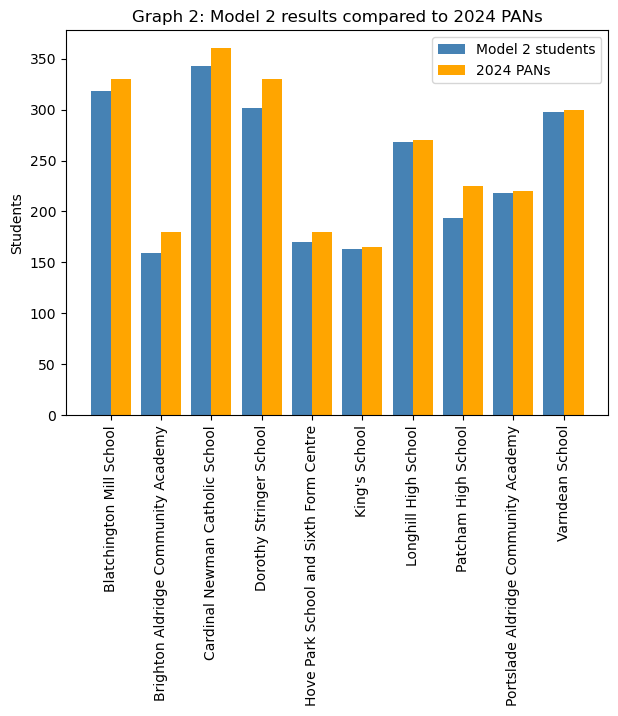

In [8]:
## create ordered lists
students_total_plot, PANs_2024_plot = list(), list()
x_axis_list = list()
for school_str in PANs["school"]:
    students_total_plot.append(int(schools[schools["establishment_name"] == school_str]["students_total"]))
    PANs_2024_plot.append(int(PANs[PANs["school"] == school_str]["pan2024"]))
    x_axis_list.append(school_str)

## plot target PAN numbers
x_axis = np.arange(len(x_axis_list))
width = 0.4
plt.figure(figsize=(7,5))
plt.title("Graph 2: Model 2 results compared to 2024 PANs")
plt.bar(x_axis - (width / 2), students_total_plot, width, color="steelblue", label="Model 2 students")
plt.bar(x_axis + (width / 2), PANs_2024_plot, width, color="orange", label="2024 PANs")
plt.xticks(x_axis, x_axis_list, rotation=90)
plt.ylabel("Students")
plt.legend()
plt.show()
plt.close()

#### Model 2.1:

As previously mentioned, the first model optimises using the logic that each school proceeds to select the closest LSOA to it until taking any further LSOAs exceeds its allocated PAN. This version prioritises selecting LSOAs within its catchment area if any area available.
The model applies the following workflow:
- Order the schools starting from "Dorothy Stringer School" followed by the next closest school (School B), School B is then followed by its next closest (excluding "Dorothy Stinger School"), and so on.
- Each one of the 10 schools selects one LSOA (priority within its catchment) and takes in all the 5 year olds within it if that does not lead to exceeding its PAN
- We repeat for as many rounds as needed until all schools have almost reached their PANs

In [20]:
## Run the model
reset_parameters()
Optimise_PANsCatchment_Schools(schools=schools, students_lsoa=students, PANs=PANs)
print("Finalised model run")

Finalised model run


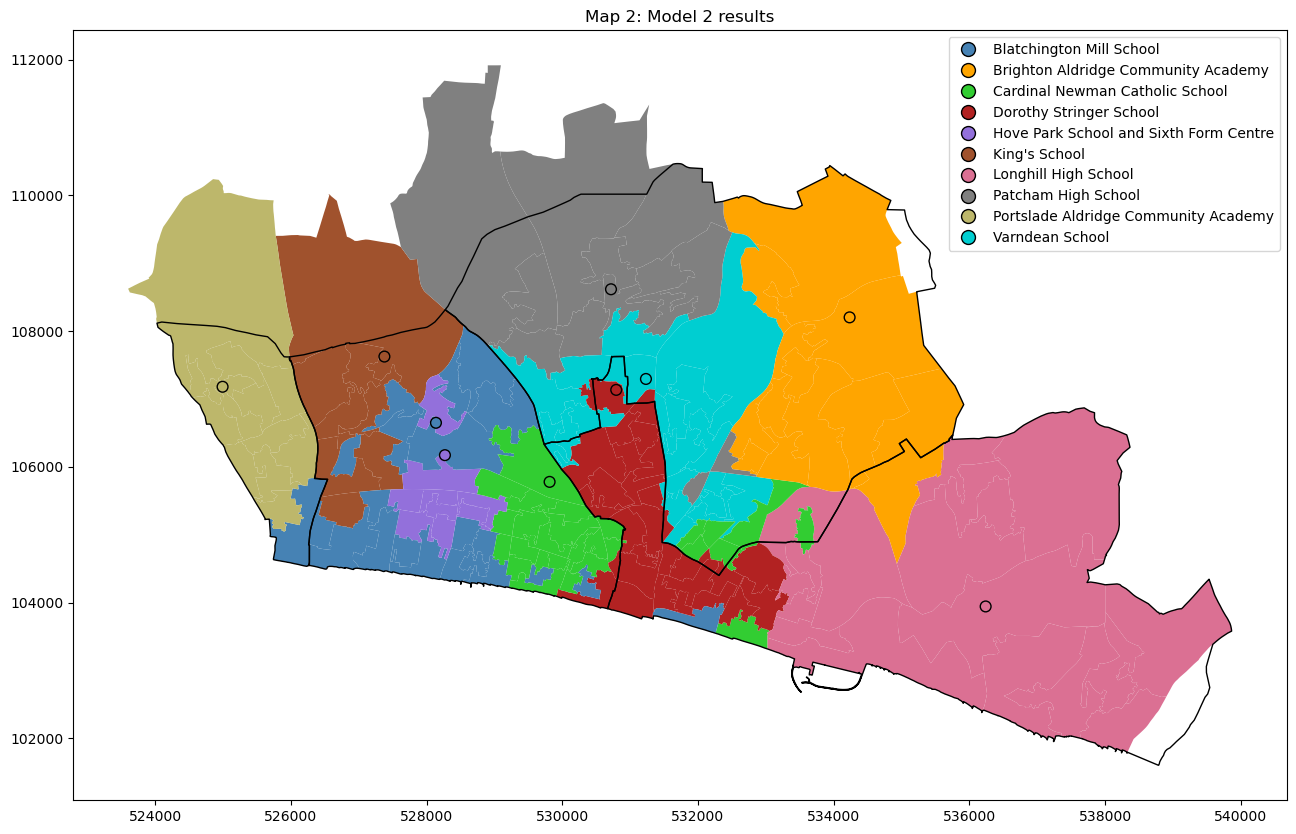

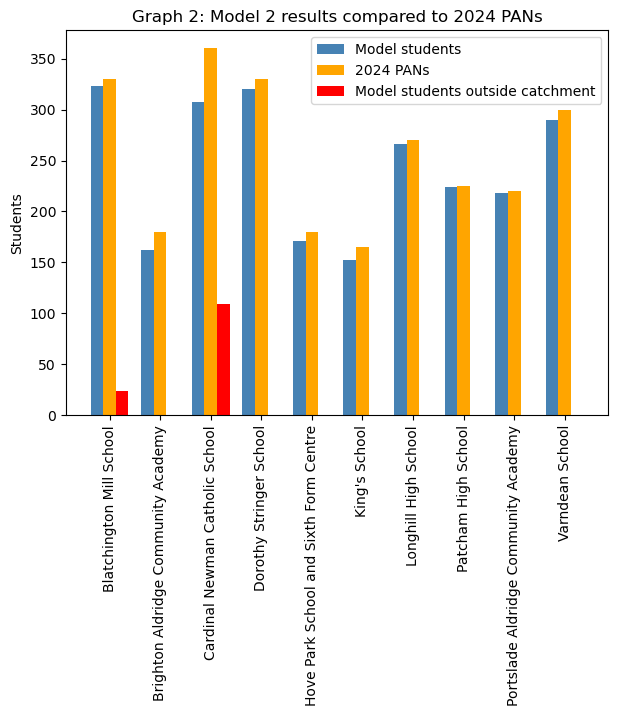

In [21]:
## Plot the map
students["colour"] = [colours[students.at[i, "school"]] for i in students.index]
schools["colour"] = [colours[schools.at[i, "establishment_name"]] for i in schools.index]
fig = students.plot(color=students["colour"], legend=True, figsize=(20,10))
schools.plot(ax=fig, color=schools["colour"], edgecolor='black', markersize=60, legend=True)
catchment.plot(ax=fig, facecolor="none", edgecolor="black", label="Catchment")
plt.title("Map 2: Model 2 results")
plt.legend(handles=create_custom_legend_handles())
plt.show()
plt.close()

## plot target PAN numbers
## create ordered lists
students_total_plot, PANs_2024_plot, students_outside_catchment = list(), list(), list()
x_axis_list = list()
for school_str in PANs["school"]:
    students_total_plot.append(int(schools[schools["establishment_name"] == school_str]["students_total"]))
    PANs_2024_plot.append(int(PANs[PANs["school"] == school_str]["pan2024"]))
    students_outside_catchment.append(sum( students[(students["school"] == school_str) & (students["catchment_ID"] != students["catchment_ID_school"])]["5_est"] ) )
    x_axis_list.append(school_str)

## Generate the graph
x_axis = np.arange(len(x_axis_list))
width = 0.25
plt.figure(figsize=(7,5))
plt.title("Graph 2: Model 2 results compared to 2024 PANs")
plt.bar(x_axis - width, students_total_plot, width, color="steelblue", label="Model students")
plt.bar(x_axis , PANs_2024_plot, width, color="orange", label="2024 PANs")
plt.bar(x_axis + width, students_outside_catchment, width, color="red", label="Model students outside catchment")
plt.xticks(x_axis, x_axis_list, rotation=90)
plt.ylabel("Students")
plt.legend()
plt.show()
plt.close()

##### Observations: number of students from outside each school's catchment

     catchment_ID  catchment_ID_school
0               2                    2
1               2                    2
2               2                    2
3               2                    2
4               2                    2
..            ...                  ...
160             4                    4
161             4                    4
162             4                    4
163             4                    4
164             4                    4

[165 rows x 2 columns]
[24, 0, 109, 0, 0, 0, 0, 0, 0, 0]


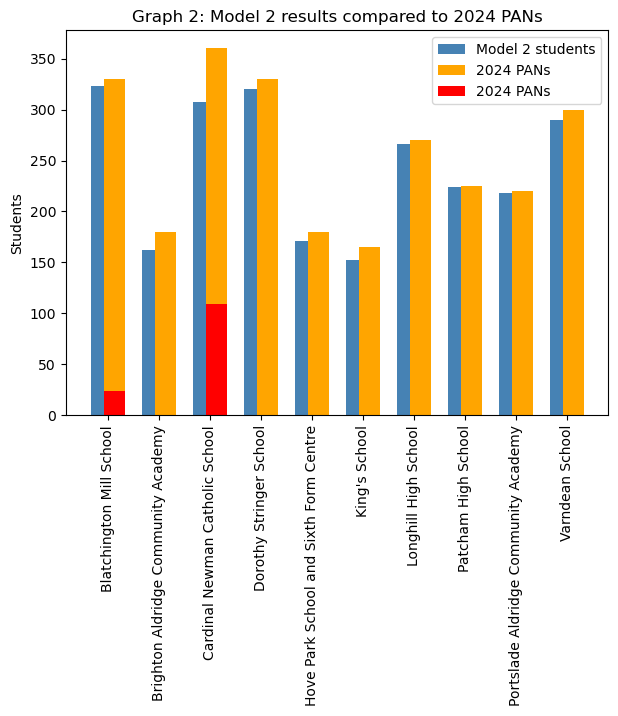

In [11]:
students_outside_catchment = []
for school_str in PANs["school"]:
    students_outside_catchment.append(sum( students[(students["school"] == school_str) & (students["catchment_ID"] != students["catchment_ID_school"])]["5_est"] ) )

print(students[["catchment_ID", "catchment_ID_school"]])

print(students_outside_catchment)


## Generate the graph
x_axis = np.arange(len(x_axis_list))
width = 0.4
plt.figure(figsize=(7,5))
plt.title("Graph 2: Model 2 results compared to 2024 PANs")
plt.bar(x_axis - (width / 3), students_total_plot, width, color="steelblue", label="Model 2 students")
plt.bar(x_axis + (width / 3), PANs_2024_plot, width, color="orange", label="2024 PANs")
plt.bar(x_axis + (width / 3), students_outside_catchment, width, color="red", label="2024 PANs")
plt.xticks(x_axis, x_axis_list, rotation=90)
plt.ylabel("Students")
plt.legend()
plt.show()
plt.close()

